In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)
data_df['sbj'] += 1

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(30464, 4) (30464, 4)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3000)

Epoch 1/3000
1/1 [==============================] - 1506s 1506s/step - loss: 164077.4062
Epoch 2/3000
1/1 [==============================] - 0s 306ms/step - loss: 163382.9688
Epoch 3/3000
1/1 [==============================] - 0s 224ms/step - loss: 162888.5000
Epoch 4/3000
1/1 [==============================] - 0s 229ms/step - loss: 162476.2188
Epoch 5/3000
1/1 [==============================] - 0s 206ms/step - loss: 162110.8281
Epoch 6/3000
1/1 [==============================] - 0s 219ms/step - loss: 161775.8750
Epoch 7/3000
1/1 [==============================] - 0s 199ms/step - loss: 161461.9688
Epoch 8/3000
1/1 [==============================] - 0s 220ms/step - loss: 161162.9375
Epoch 9/3000
1/1 [==============================] - 0s 209ms/step - loss: 160874.5469
Epoch 10/3000
1/1 [==============================] - 0s 203ms/step - loss: 160594.0625
Epoch 11/3000
1/1 [==============================] - 0s 230ms/step - loss: 160319.8281
Epoch 12/3000
1/1 [==============================

1/1 [==============================] - 1s 650ms/step - loss: 144342.8594
Epoch 96/3000
1/1 [==============================] - 1s 623ms/step - loss: 144198.3750
Epoch 97/3000
1/1 [==============================] - 1s 560ms/step - loss: 144054.5469
Epoch 98/3000
1/1 [==============================] - 0s 476ms/step - loss: 143911.3750
Epoch 99/3000
1/1 [==============================] - 0s 391ms/step - loss: 143768.8594
Epoch 100/3000
1/1 [==============================] - 1s 584ms/step - loss: 143626.9688
Epoch 101/3000
1/1 [==============================] - 1s 520ms/step - loss: 143485.7031
Epoch 102/3000
1/1 [==============================] - 1s 558ms/step - loss: 143345.0469
Epoch 103/3000
1/1 [==============================] - 0s 488ms/step - loss: 143205.0156
Epoch 104/3000
1/1 [==============================] - 1s 608ms/step - loss: 143065.5469
Epoch 105/3000
1/1 [==============================] - 1s 682ms/step - loss: 142926.6562
Epoch 106/3000
1/1 [==============================]

1/1 [==============================] - 1s 591ms/step - loss: 133282.2500
Epoch 189/3000
1/1 [==============================] - 1s 546ms/step - loss: 133186.6875
Epoch 190/3000
1/1 [==============================] - 1s 530ms/step - loss: 133091.5156
Epoch 191/3000
1/1 [==============================] - 1s 602ms/step - loss: 132996.7031
Epoch 192/3000
1/1 [==============================] - 1s 634ms/step - loss: 132902.2500
Epoch 193/3000
1/1 [==============================] - 1s 610ms/step - loss: 132808.1562
Epoch 194/3000
1/1 [==============================] - 1s 612ms/step - loss: 132714.4219
Epoch 195/3000
1/1 [==============================] - 1s 611ms/step - loss: 132621.0312
Epoch 196/3000
1/1 [==============================] - 1s 671ms/step - loss: 132527.9688
Epoch 197/3000
1/1 [==============================] - 1s 594ms/step - loss: 132435.2344
Epoch 198/3000
1/1 [==============================] - 1s 626ms/step - loss: 132342.8281
Epoch 199/3000
1/1 [===========================

1/1 [==============================] - 1s 630ms/step - loss: 124456.4844
Epoch 282/3000
1/1 [==============================] - 1s 601ms/step - loss: 124352.1562
Epoch 283/3000
1/1 [==============================] - 1s 589ms/step - loss: 124247.8281
Epoch 284/3000
1/1 [==============================] - 1s 626ms/step - loss: 124143.5547
Epoch 285/3000
1/1 [==============================] - 1s 637ms/step - loss: 124039.3047
Epoch 286/3000
1/1 [==============================] - 1s 620ms/step - loss: 123935.0938
Epoch 287/3000
1/1 [==============================] - 1s 591ms/step - loss: 123830.9219
Epoch 288/3000
1/1 [==============================] - 1s 594ms/step - loss: 123726.7969
Epoch 289/3000
1/1 [==============================] - 1s 575ms/step - loss: 123622.7344
Epoch 290/3000
1/1 [==============================] - 1s 589ms/step - loss: 123518.7344
Epoch 291/3000
1/1 [==============================] - 0s 487ms/step - loss: 123414.7656
Epoch 292/3000
1/1 [===========================

1/1 [==============================] - 1s 572ms/step - loss: 115074.9922
Epoch 375/3000
1/1 [==============================] - 1s 605ms/step - loss: 114979.9688
Epoch 376/3000
1/1 [==============================] - 1s 651ms/step - loss: 114885.0312
Epoch 377/3000
1/1 [==============================] - 1s 635ms/step - loss: 114790.3828
Epoch 378/3000
1/1 [==============================] - 1s 570ms/step - loss: 114695.8438
Epoch 379/3000
1/1 [==============================] - 1s 521ms/step - loss: 114601.6172
Epoch 380/3000
1/1 [==============================] - 1s 581ms/step - loss: 114507.4531
Epoch 381/3000
1/1 [==============================] - 1s 618ms/step - loss: 114413.6016
Epoch 382/3000
1/1 [==============================] - 1s 577ms/step - loss: 114319.8516
Epoch 383/3000
1/1 [==============================] - 1s 573ms/step - loss: 114226.3828
Epoch 384/3000
1/1 [==============================] - 1s 597ms/step - loss: 114133.0156
Epoch 385/3000
1/1 [===========================

1/1 [==============================] - 1s 537ms/step - loss: 107086.8984
Epoch 468/3000
1/1 [==============================] - 1s 638ms/step - loss: 107010.9297
Epoch 469/3000
1/1 [==============================] - 1s 611ms/step - loss: 106935.2969
Epoch 470/3000
1/1 [==============================] - 1s 623ms/step - loss: 106859.7266
Epoch 471/3000
1/1 [==============================] - 1s 660ms/step - loss: 106784.4922
Epoch 472/3000
1/1 [==============================] - 1s 585ms/step - loss: 106709.2969
Epoch 473/3000
1/1 [==============================] - 1s 594ms/step - loss: 106634.4375
Epoch 474/3000
1/1 [==============================] - 1s 555ms/step - loss: 106559.6172
Epoch 475/3000
1/1 [==============================] - 1s 539ms/step - loss: 106485.1406
Epoch 476/3000
1/1 [==============================] - 1s 573ms/step - loss: 106410.6719
Epoch 477/3000
1/1 [==============================] - 1s 504ms/step - loss: 106336.5625
Epoch 478/3000
1/1 [===========================

1/1 [==============================] - 0s 442ms/step - loss: 100695.4375
Epoch 561/3000
1/1 [==============================] - 0s 433ms/step - loss: 100633.0156
Epoch 562/3000
1/1 [==============================] - 0s 443ms/step - loss: 100570.5703
Epoch 563/3000
1/1 [==============================] - 0s 454ms/step - loss: 100508.3750
Epoch 564/3000
1/1 [==============================] - 0s 465ms/step - loss: 100446.1719
Epoch 565/3000
1/1 [==============================] - 0s 443ms/step - loss: 100384.2031
Epoch 566/3000
1/1 [==============================] - 0s 437ms/step - loss: 100322.2422
Epoch 567/3000
1/1 [==============================] - 0s 445ms/step - loss: 100260.5078
Epoch 568/3000
1/1 [==============================] - 0s 468ms/step - loss: 100198.7734
Epoch 569/3000
1/1 [==============================] - 0s 441ms/step - loss: 100137.2656
Epoch 570/3000
1/1 [==============================] - 1s 639ms/step - loss: 100075.7812
Epoch 571/3000
1/1 [===========================

1/1 [==============================] - 0s 492ms/step - loss: 95298.7656
Epoch 655/3000
1/1 [==============================] - 0s 470ms/step - loss: 95246.1094
Epoch 656/3000
1/1 [==============================] - 1s 549ms/step - loss: 95193.7031
Epoch 657/3000
1/1 [==============================] - 1s 513ms/step - loss: 95141.2500
Epoch 658/3000
1/1 [==============================] - 1s 594ms/step - loss: 95089.0312
Epoch 659/3000
1/1 [==============================] - 1s 547ms/step - loss: 95036.7656
Epoch 660/3000
1/1 [==============================] - 1s 547ms/step - loss: 94984.7500
Epoch 661/3000
1/1 [==============================] - 1s 568ms/step - loss: 94932.6641
Epoch 662/3000
1/1 [==============================] - 1s 562ms/step - loss: 94880.8438
Epoch 663/3000
1/1 [==============================] - 1s 560ms/step - loss: 94828.9375
Epoch 664/3000
1/1 [==============================] - 1s 566ms/step - loss: 94777.3125
Epoch 665/3000
1/1 [==============================] - 1s 6

1/1 [==============================] - 1s 671ms/step - loss: 90757.2578
Epoch 749/3000
1/1 [==============================] - 1s 659ms/step - loss: 90712.9219
Epoch 750/3000
1/1 [==============================] - 1s 568ms/step - loss: 90669.0625
Epoch 751/3000
1/1 [==============================] - 1s 591ms/step - loss: 90624.8906
Epoch 752/3000
1/1 [==============================] - 1s 574ms/step - loss: 90581.2031
Epoch 753/3000
1/1 [==============================] - 1s 595ms/step - loss: 90537.2031
Epoch 754/3000
1/1 [==============================] - 1s 581ms/step - loss: 90493.6797
Epoch 755/3000
1/1 [==============================] - 1s 586ms/step - loss: 90449.8516
Epoch 756/3000
1/1 [==============================] - 1s 597ms/step - loss: 90406.5078
Epoch 757/3000
1/1 [==============================] - 1s 642ms/step - loss: 90362.8281
Epoch 758/3000
1/1 [==============================] - 1s 606ms/step - loss: 90319.6562
Epoch 759/3000
1/1 [==============================] - 1s 6

1/1 [==============================] - 0s 360ms/step - loss: 86970.9531
Epoch 843/3000
1/1 [==============================] - 1s 782ms/step - loss: 86934.2266
Epoch 844/3000
1/1 [==============================] - 1s 659ms/step - loss: 86898.1875
Epoch 845/3000
1/1 [==============================] - 1s 609ms/step - loss: 86861.6172
Epoch 846/3000
1/1 [==============================] - 0s 406ms/step - loss: 86825.7422
Epoch 847/3000
1/1 [==============================] - 1s 698ms/step - loss: 86789.3281
Epoch 848/3000
1/1 [==============================] - 1s 589ms/step - loss: 86753.6172
Epoch 849/3000
1/1 [==============================] - 0s 385ms/step - loss: 86717.3438
Epoch 850/3000
1/1 [==============================] - 0s 321ms/step - loss: 86681.7812
Epoch 851/3000
1/1 [==============================] - 0s 393ms/step - loss: 86645.6875
Epoch 852/3000
1/1 [==============================] - 1s 598ms/step - loss: 86610.2969
Epoch 853/3000
1/1 [==============================] - 1s 6

1/1 [==============================] - 1s 524ms/step - loss: 83883.4688
Epoch 937/3000
1/1 [==============================] - 0s 378ms/step - loss: 83853.6719
Epoch 938/3000
1/1 [==============================] - 0s 457ms/step - loss: 83824.7812
Epoch 939/3000
1/1 [==============================] - 0s 371ms/step - loss: 83795.1250
Epoch 940/3000
1/1 [==============================] - 1s 528ms/step - loss: 83766.3438
Epoch 941/3000
1/1 [==============================] - 0s 386ms/step - loss: 83736.8438
Epoch 942/3000
1/1 [==============================] - 0s 430ms/step - loss: 83708.2109
Epoch 943/3000
1/1 [==============================] - 0s 461ms/step - loss: 83678.8516
Epoch 944/3000
1/1 [==============================] - 1s 769ms/step - loss: 83650.3750
Epoch 945/3000
1/1 [==============================] - 1s 1s/step - loss: 83621.1328
Epoch 946/3000
1/1 [==============================] - 1s 881ms/step - loss: 83592.7969
Epoch 947/3000
1/1 [==============================] - 1s 909m

1/1 [==============================] - 0s 430ms/step - loss: 81414.7266
Epoch 1031/3000
1/1 [==============================] - 0s 467ms/step - loss: 81391.3359
Epoch 1032/3000
1/1 [==============================] - 1s 612ms/step - loss: 81368.7031
Epoch 1033/3000
1/1 [==============================] - 1s 596ms/step - loss: 81345.3750
Epoch 1034/3000
1/1 [==============================] - 1s 675ms/step - loss: 81323.1094
Epoch 1035/3000
1/1 [==============================] - 1s 707ms/step - loss: 81300.0000
Epoch 1036/3000
1/1 [==============================] - 1s 666ms/step - loss: 81277.4688
Epoch 1037/3000
1/1 [==============================] - 1s 590ms/step - loss: 81254.2969
Epoch 1038/3000
1/1 [==============================] - 1s 612ms/step - loss: 81232.2969
Epoch 1039/3000
1/1 [==============================] - 1s 567ms/step - loss: 81209.5312
Epoch 1040/3000
1/1 [==============================] - 1s 503ms/step - loss: 81187.2656
Epoch 1041/3000
1/1 [===========================

1/1 [==============================] - 1s 790ms/step - loss: 79539.8125
Epoch 1124/3000
1/1 [==============================] - 1s 761ms/step - loss: 79522.4531
Epoch 1125/3000
1/1 [==============================] - 1s 1s/step - loss: 79503.7891
Epoch 1126/3000
1/1 [==============================] - 1s 836ms/step - loss: 79486.1719
Epoch 1127/3000
1/1 [==============================] - 1s 658ms/step - loss: 79467.7422
Epoch 1128/3000
1/1 [==============================] - 1s 683ms/step - loss: 79450.7812
Epoch 1129/3000
1/1 [==============================] - 1s 621ms/step - loss: 79432.9531
Epoch 1130/3000
1/1 [==============================] - 1s 767ms/step - loss: 79416.6016
Epoch 1131/3000
1/1 [==============================] - 1s 884ms/step - loss: 79399.4922
Epoch 1132/3000
1/1 [==============================] - 1s 894ms/step - loss: 79384.1719
Epoch 1133/3000
1/1 [==============================] - 1s 896ms/step - loss: 79367.9688
Epoch 1134/3000
1/1 [==============================

1/1 [==============================] - 1s 514ms/step - loss: 78105.2266
Epoch 1217/3000
1/1 [==============================] - 1s 537ms/step - loss: 78090.9922
Epoch 1218/3000
1/1 [==============================] - 0s 476ms/step - loss: 78078.9062
Epoch 1219/3000
1/1 [==============================] - 1s 718ms/step - loss: 78065.9062
Epoch 1220/3000
1/1 [==============================] - 1s 610ms/step - loss: 78052.5391
Epoch 1221/3000
1/1 [==============================] - 1s 567ms/step - loss: 78037.4688
Epoch 1222/3000
1/1 [==============================] - 0s 436ms/step - loss: 78024.2109
Epoch 1223/3000
1/1 [==============================] - 1s 683ms/step - loss: 78009.9531
Epoch 1224/3000
1/1 [==============================] - 1s 833ms/step - loss: 77997.7812
Epoch 1225/3000
1/1 [==============================] - 1s 703ms/step - loss: 77985.0781
Epoch 1226/3000
1/1 [==============================] - 1s 653ms/step - loss: 77973.1719
Epoch 1227/3000
1/1 [===========================

1/1 [==============================] - 1s 575ms/step - loss: 77046.0469
Epoch 1310/3000
1/1 [==============================] - 1s 603ms/step - loss: 77038.5781
Epoch 1311/3000
1/1 [==============================] - 1s 598ms/step - loss: 77029.5938
Epoch 1312/3000
1/1 [==============================] - 1s 622ms/step - loss: 77022.3438
Epoch 1313/3000
1/1 [==============================] - 1s 601ms/step - loss: 77012.7031
Epoch 1314/3000
1/1 [==============================] - 1s 580ms/step - loss: 77004.7969
Epoch 1315/3000
1/1 [==============================] - 1s 674ms/step - loss: 76994.1875
Epoch 1316/3000
1/1 [==============================] - 1s 573ms/step - loss: 76985.8906
Epoch 1317/3000
1/1 [==============================] - 1s 559ms/step - loss: 76975.0234
Epoch 1318/3000
1/1 [==============================] - 0s 445ms/step - loss: 76966.9141
Epoch 1319/3000
1/1 [==============================] - 0s 403ms/step - loss: 76956.9531
Epoch 1320/3000
1/1 [===========================

1/1 [==============================] - 1s 691ms/step - loss: 76327.2734
Epoch 1403/3000
1/1 [==============================] - 1s 578ms/step - loss: 76319.4922
Epoch 1404/3000
1/1 [==============================] - 0s 399ms/step - loss: 76313.9844
Epoch 1405/3000
1/1 [==============================] - 0s 438ms/step - loss: 76306.6484
Epoch 1406/3000
1/1 [==============================] - 1s 598ms/step - loss: 76301.4844
Epoch 1407/3000
1/1 [==============================] - 1s 606ms/step - loss: 76294.5781
Epoch 1408/3000
1/1 [==============================] - 1s 563ms/step - loss: 76289.7422
Epoch 1409/3000
1/1 [==============================] - 0s 392ms/step - loss: 76282.0625
Epoch 1410/3000
1/1 [==============================] - 0s 411ms/step - loss: 76277.1875
Epoch 1411/3000
1/1 [==============================] - 0s 421ms/step - loss: 76269.5156
Epoch 1412/3000
1/1 [==============================] - 0s 439ms/step - loss: 76264.0625
Epoch 1413/3000
1/1 [===========================

1/1 [==============================] - 1s 598ms/step - loss: 75811.7422
Epoch 1496/3000
1/1 [==============================] - 1s 531ms/step - loss: 75796.8594
Epoch 1497/3000
1/1 [==============================] - 0s 372ms/step - loss: 75781.1328
Epoch 1498/3000
1/1 [==============================] - 0s 489ms/step - loss: 75774.4375
Epoch 1499/3000
1/1 [==============================] - 1s 592ms/step - loss: 75765.9062
Epoch 1500/3000
1/1 [==============================] - 0s 480ms/step - loss: 75761.5469
Epoch 1501/3000
1/1 [==============================] - 0s 349ms/step - loss: 75757.6328
Epoch 1502/3000
1/1 [==============================] - 1s 631ms/step - loss: 75756.8906
Epoch 1503/3000
1/1 [==============================] - 0s 498ms/step - loss: 75757.3047
Epoch 1504/3000
1/1 [==============================] - 0s 355ms/step - loss: 75761.3594
Epoch 1505/3000
1/1 [==============================] - 1s 589ms/step - loss: 75763.6562
Epoch 1506/3000
1/1 [===========================

1/1 [==============================] - 0s 348ms/step - loss: 75358.0938
Epoch 1589/3000
1/1 [==============================] - 0s 338ms/step - loss: 75361.0391
Epoch 1590/3000
1/1 [==============================] - 0s 333ms/step - loss: 75357.2734
Epoch 1591/3000
1/1 [==============================] - 0s 301ms/step - loss: 75362.4922
Epoch 1592/3000
1/1 [==============================] - 0s 311ms/step - loss: 75361.0000
Epoch 1593/3000
1/1 [==============================] - 0s 323ms/step - loss: 75369.1250
Epoch 1594/3000
1/1 [==============================] - 0s 427ms/step - loss: 75357.7656
Epoch 1595/3000
1/1 [==============================] - 0s 465ms/step - loss: 75357.9531
Epoch 1596/3000
1/1 [==============================] - 1s 507ms/step - loss: 75347.2656
Epoch 1597/3000
1/1 [==============================] - 0s 361ms/step - loss: 75341.1875
Epoch 1598/3000
1/1 [==============================] - 1s 552ms/step - loss: 75332.4219
Epoch 1599/3000
1/1 [===========================

1/1 [==============================] - 1s 738ms/step - loss: 75007.5312
Epoch 1683/3000
1/1 [==============================] - 1s 629ms/step - loss: 75008.3672
Epoch 1684/3000
1/1 [==============================] - 1s 629ms/step - loss: 75001.3203
Epoch 1685/3000
1/1 [==============================] - 1s 512ms/step - loss: 75002.0781
Epoch 1686/3000
1/1 [==============================] - 1s 701ms/step - loss: 75006.8828
Epoch 1687/3000
1/1 [==============================] - 1s 729ms/step - loss: 75021.2422
Epoch 1688/3000
1/1 [==============================] - 1s 602ms/step - loss: 75027.3828
Epoch 1689/3000
1/1 [==============================] - 1s 713ms/step - loss: nan
Epoch 1690/3000
1/1 [==============================] - 1s 682ms/step - loss: 75028.8906
Epoch 1691/3000
1/1 [==============================] - 1s 611ms/step - loss: 75020.2969
Epoch 1692/3000
1/1 [==============================] - 1s 777ms/step - loss: 74991.9844
Epoch 1693/3000
1/1 [==============================] - 

1/1 [==============================] - 1s 625ms/step - loss: 74778.0625
Epoch 1776/3000
1/1 [==============================] - 1s 617ms/step - loss: 74784.2188
Epoch 1777/3000
1/1 [==============================] - 1s 589ms/step - loss: 74785.7656
Epoch 1778/3000
1/1 [==============================] - 1s 653ms/step - loss: 74772.0312
Epoch 1779/3000
1/1 [==============================] - 1s 768ms/step - loss: nan
Epoch 1780/3000
1/1 [==============================] - 1s 674ms/step - loss: nan
Epoch 1781/3000
1/1 [==============================] - 1s 694ms/step - loss: 74733.7266
Epoch 1782/3000
1/1 [==============================] - 1s 580ms/step - loss: 74728.6328
Epoch 1783/3000
1/1 [==============================] - 1s 630ms/step - loss: 74727.8438
Epoch 1784/3000
1/1 [==============================] - 1s 719ms/step - loss: 74733.2734
Epoch 1785/3000
1/1 [==============================] - 1s 694ms/step - loss: 74736.8281
Epoch 1786/3000
1/1 [==============================] - 1s 613m

1/1 [==============================] - 0s 291ms/step - loss: nan
Epoch 1871/3000
1/1 [==============================] - 0s 303ms/step - loss: 74554.0625
Epoch 1872/3000
1/1 [==============================] - 0s 291ms/step - loss: 74538.6016
Epoch 1873/3000
1/1 [==============================] - 0s 292ms/step - loss: nan
Epoch 1874/3000
1/1 [==============================] - 0s 294ms/step - loss: 74521.6641
Epoch 1875/3000
1/1 [==============================] - 0s 300ms/step - loss: 74516.3672
Epoch 1876/3000
1/1 [==============================] - 0s 302ms/step - loss: 74514.1484
Epoch 1877/3000
1/1 [==============================] - 0s 322ms/step - loss: 74517.6406
Epoch 1878/3000
1/1 [==============================] - 0s 304ms/step - loss: 74520.6562
Epoch 1879/3000
1/1 [==============================] - 0s 471ms/step - loss: 74519.0156
Epoch 1880/3000
1/1 [==============================] - 0s 433ms/step - loss: 74521.1406
Epoch 1881/3000
1/1 [==============================] - 1s 670m

1/1 [==============================] - 0s 302ms/step - loss: 74427.9297
Epoch 1966/3000
1/1 [==============================] - 0s 317ms/step - loss: 74386.1797
Epoch 1967/3000
1/1 [==============================] - 0s 298ms/step - loss: 74367.0312
Epoch 1968/3000
1/1 [==============================] - 1s 586ms/step - loss: 74350.3359
Epoch 1969/3000
1/1 [==============================] - 0s 323ms/step - loss: 74342.8828
Epoch 1970/3000
1/1 [==============================] - 0s 312ms/step - loss: 74338.6953
Epoch 1971/3000
1/1 [==============================] - 0s 373ms/step - loss: 74335.0625
Epoch 1972/3000
1/1 [==============================] - 0s 320ms/step - loss: 74333.3594
Epoch 1973/3000
1/1 [==============================] - 0s 301ms/step - loss: 74334.1719
Epoch 1974/3000
1/1 [==============================] - 0s 305ms/step - loss: 74335.4531
Epoch 1975/3000
1/1 [==============================] - 0s 328ms/step - loss: 74345.0078
Epoch 1976/3000
1/1 [===========================

1/1 [==============================] - 0s 282ms/step - loss: 74215.8047
Epoch 2059/3000
1/1 [==============================] - 0s 284ms/step - loss: 74204.4297
Epoch 2060/3000
1/1 [==============================] - 0s 283ms/step - loss: 74194.7031
Epoch 2061/3000
1/1 [==============================] - 0s 287ms/step - loss: 74188.8047
Epoch 2062/3000
1/1 [==============================] - 0s 311ms/step - loss: 74187.2422
Epoch 2063/3000
1/1 [==============================] - 0s 293ms/step - loss: 74184.9219
Epoch 2064/3000
1/1 [==============================] - 0s 284ms/step - loss: 74188.8906
Epoch 2065/3000
1/1 [==============================] - 0s 301ms/step - loss: 74192.8906
Epoch 2066/3000
1/1 [==============================] - 0s 281ms/step - loss: 74198.7031
Epoch 2067/3000
1/1 [==============================] - 0s 283ms/step - loss: nan
Epoch 2068/3000
1/1 [==============================] - 0s 283ms/step - loss: 74209.0625
Epoch 2069/3000
1/1 [==============================] - 

1/1 [==============================] - 0s 329ms/step - loss: 74091.3281
Epoch 2152/3000
1/1 [==============================] - 1s 585ms/step - loss: 74072.8594
Epoch 2153/3000
1/1 [==============================] - 0s 463ms/step - loss: 74066.8906
Epoch 2154/3000
1/1 [==============================] - 0s 435ms/step - loss: 74062.8125
Epoch 2155/3000
1/1 [==============================] - 0s 330ms/step - loss: 74061.6641
Epoch 2156/3000
1/1 [==============================] - 0s 375ms/step - loss: 74060.5625
Epoch 2157/3000
1/1 [==============================] - 0s 474ms/step - loss: 74059.5156
Epoch 2158/3000
1/1 [==============================] - 1s 704ms/step - loss: 74055.4531
Epoch 2159/3000
1/1 [==============================] - 1s 556ms/step - loss: 74059.6719
Epoch 2160/3000
1/1 [==============================] - 0s 323ms/step - loss: 74067.9062
Epoch 2161/3000
1/1 [==============================] - 0s 294ms/step - loss: 74092.1250
Epoch 2162/3000
1/1 [===========================

1/1 [==============================] - 0s 304ms/step - loss: 74002.4922
Epoch 2246/3000
1/1 [==============================] - 0s 305ms/step - loss: nan
Epoch 2247/3000
1/1 [==============================] - 0s 293ms/step - loss: 73987.3438
Epoch 2248/3000
1/1 [==============================] - 0s 288ms/step - loss: nan
Epoch 2249/3000
1/1 [==============================] - 0s 283ms/step - loss: 73958.7422
Epoch 2250/3000
1/1 [==============================] - 0s 279ms/step - loss: 73956.5703
Epoch 2251/3000
1/1 [==============================] - 0s 290ms/step - loss: nan
Epoch 2252/3000
1/1 [==============================] - 0s 350ms/step - loss: nan
Epoch 2253/3000
1/1 [==============================] - 0s 312ms/step - loss: 73996.3203
Epoch 2254/3000
1/1 [==============================] - 0s 307ms/step - loss: 74034.1719
Epoch 2255/3000
1/1 [==============================] - 0s 302ms/step - loss: nan
Epoch 2256/3000
1/1 [==============================] - 0s 303ms/step - loss: nan
Ep

1/1 [==============================] - 0s 275ms/step - loss: 73878.3281
Epoch 2343/3000
1/1 [==============================] - 0s 287ms/step - loss: nan
Epoch 2344/3000
1/1 [==============================] - 0s 300ms/step - loss: nan
Epoch 2345/3000
1/1 [==============================] - 0s 276ms/step - loss: nan
Epoch 2346/3000
1/1 [==============================] - 0s 279ms/step - loss: nan
Epoch 2347/3000
1/1 [==============================] - 0s 278ms/step - loss: nan
Epoch 2348/3000
1/1 [==============================] - 0s 300ms/step - loss: nan
Epoch 2349/3000
1/1 [==============================] - 0s 284ms/step - loss: 73902.9609
Epoch 2350/3000
1/1 [==============================] - 0s 295ms/step - loss: 73890.5312
Epoch 2351/3000
1/1 [==============================] - 0s 285ms/step - loss: nan
Epoch 2352/3000
1/1 [==============================] - 0s 284ms/step - loss: nan
Epoch 2353/3000
1/1 [==============================] - 0s 363ms/step - loss: nan
Epoch 2354/3000
1/1 [==

1/1 [==============================] - 0s 294ms/step - loss: nan
Epoch 2440/3000
1/1 [==============================] - 0s 329ms/step - loss: nan
Epoch 2441/3000
1/1 [==============================] - 0s 368ms/step - loss: nan
Epoch 2442/3000
1/1 [==============================] - 1s 525ms/step - loss: 73813.4688
Epoch 2443/3000
1/1 [==============================] - 0s 308ms/step - loss: nan
Epoch 2444/3000
1/1 [==============================] - 0s 314ms/step - loss: 73803.3594
Epoch 2445/3000
1/1 [==============================] - 0s 326ms/step - loss: 73805.9844
Epoch 2446/3000
1/1 [==============================] - 0s 319ms/step - loss: 73778.0781
Epoch 2447/3000
1/1 [==============================] - 0s 292ms/step - loss: nan
Epoch 2448/3000
1/1 [==============================] - 0s 300ms/step - loss: nan
Epoch 2449/3000
1/1 [==============================] - 0s 298ms/step - loss: 73791.0859
Epoch 2450/3000
1/1 [==============================] - 0s 284ms/step - loss: 73792.4141
Ep

Epoch 2536/3000
1/1 [==============================] - 0s 310ms/step - loss: nan
Epoch 2537/3000
1/1 [==============================] - 0s 296ms/step - loss: nan
Epoch 2538/3000
1/1 [==============================] - 0s 280ms/step - loss: nan
Epoch 2539/3000
1/1 [==============================] - 0s 291ms/step - loss: nan
Epoch 2540/3000
1/1 [==============================] - 0s 289ms/step - loss: 73764.1094
Epoch 2541/3000
1/1 [==============================] - 0s 278ms/step - loss: nan
Epoch 2542/3000
1/1 [==============================] - 0s 287ms/step - loss: nan
Epoch 2543/3000
1/1 [==============================] - 0s 291ms/step - loss: 73740.6797
Epoch 2544/3000
1/1 [==============================] - 0s 277ms/step - loss: nan
Epoch 2545/3000
1/1 [==============================] - 0s 276ms/step - loss: nan
Epoch 2546/3000
1/1 [==============================] - 0s 288ms/step - loss: 73712.8125
Epoch 2547/3000
1/1 [==============================] - 0s 280ms/step - loss: 73708.1875


1/1 [==============================] - 0s 296ms/step - loss: 73686.6875
Epoch 2633/3000
1/1 [==============================] - 0s 317ms/step - loss: nan
Epoch 2634/3000
1/1 [==============================] - 0s 302ms/step - loss: nan
Epoch 2635/3000
1/1 [==============================] - 0s 278ms/step - loss: 73693.3828
Epoch 2636/3000
1/1 [==============================] - 0s 285ms/step - loss: 73698.2891
Epoch 2637/3000
1/1 [==============================] - 0s 286ms/step - loss: nan
Epoch 2638/3000
1/1 [==============================] - 0s 283ms/step - loss: 73667.2891
Epoch 2639/3000
1/1 [==============================] - 0s 289ms/step - loss: nan
Epoch 2640/3000
1/1 [==============================] - 0s 287ms/step - loss: nan
Epoch 2641/3000
1/1 [==============================] - 0s 284ms/step - loss: 73664.8594
Epoch 2642/3000
1/1 [==============================] - 0s 284ms/step - loss: 73674.5859
Epoch 2643/3000
1/1 [==============================] - 0s 281ms/step - loss: nan
Ep

1/1 [==============================] - 0s 351ms/step - loss: 73623.5625
Epoch 2728/3000
1/1 [==============================] - 0s 436ms/step - loss: 73626.7500
Epoch 2729/3000
1/1 [==============================] - 0s 498ms/step - loss: 73626.4375
Epoch 2730/3000
1/1 [==============================] - 0s 339ms/step - loss: 73636.1016
Epoch 2731/3000
1/1 [==============================] - 0s 347ms/step - loss: nan
Epoch 2732/3000
1/1 [==============================] - 0s 323ms/step - loss: nan
Epoch 2733/3000
1/1 [==============================] - 0s 348ms/step - loss: 73630.5703
Epoch 2734/3000
1/1 [==============================] - 0s 326ms/step - loss: nan
Epoch 2735/3000
1/1 [==============================] - 0s 346ms/step - loss: 73658.0234
Epoch 2736/3000
1/1 [==============================] - 0s 317ms/step - loss: 73647.1953
Epoch 2737/3000
1/1 [==============================] - 0s 404ms/step - loss: 73629.1250
Epoch 2738/3000
1/1 [==============================] - 0s 458ms/step 

1/1 [==============================] - 0s 293ms/step - loss: 73598.2734
Epoch 2823/3000
1/1 [==============================] - 0s 323ms/step - loss: 73591.8125
Epoch 2824/3000
1/1 [==============================] - 0s 428ms/step - loss: nan
Epoch 2825/3000
1/1 [==============================] - 0s 371ms/step - loss: 73591.0781
Epoch 2826/3000
1/1 [==============================] - 0s 303ms/step - loss: nan
Epoch 2827/3000
1/1 [==============================] - 0s 331ms/step - loss: 73592.6406
Epoch 2828/3000
1/1 [==============================] - 0s 331ms/step - loss: 73594.2500
Epoch 2829/3000
1/1 [==============================] - 0s 347ms/step - loss: 73583.4688
Epoch 2830/3000
1/1 [==============================] - 0s 306ms/step - loss: 73586.7031
Epoch 2831/3000
1/1 [==============================] - 0s 300ms/step - loss: 73580.4609
Epoch 2832/3000
1/1 [==============================] - 0s 289ms/step - loss: nan
Epoch 2833/3000
1/1 [==============================] - 0s 294ms/step 

1/1 [==============================] - 0s 295ms/step - loss: nan
Epoch 2918/3000
1/1 [==============================] - 0s 274ms/step - loss: 73542.3672
Epoch 2919/3000
1/1 [==============================] - 0s 324ms/step - loss: nan
Epoch 2920/3000
1/1 [==============================] - 0s 302ms/step - loss: 73543.2734
Epoch 2921/3000
1/1 [==============================] - 0s 290ms/step - loss: 73552.1016
Epoch 2922/3000
1/1 [==============================] - 0s 282ms/step - loss: 73548.5781
Epoch 2923/3000
1/1 [==============================] - 0s 287ms/step - loss: nan
Epoch 2924/3000
1/1 [==============================] - 0s 318ms/step - loss: 73585.1328
Epoch 2925/3000
1/1 [==============================] - 0s 306ms/step - loss: 73580.0859
Epoch 2926/3000
1/1 [==============================] - 0s 309ms/step - loss: 73558.8672
Epoch 2927/3000
1/1 [==============================] - 0s 286ms/step - loss: nan
Epoch 2928/3000
1/1 [==============================] - 0s 298ms/step - loss:

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

952/952 [==============================] - 1s 283us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'val1': [],
            'val2':[],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['val1'].append(ts_df.item_value_0[s])
        pred_bhv['val2'].append(ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [12]:
pred_bhv['diff'] = pred_bhv['val2'] - pred_bhv['val1']

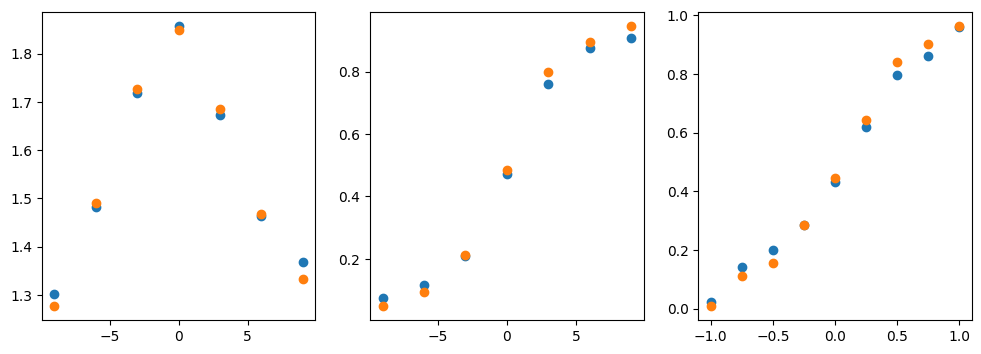

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['rt'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean());

plt.subplot(132)
plt.scatter(x=pred_bhv.groupby(by='diff')['diff'].mean(), y=pred_bhv.groupby(by='diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean());

plt.subplot(133)
plt.scatter(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(), y=pred_bhv.groupby(by='gaze_diff')['ch'].mean());
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean());

In [1]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v_train[:, 1], alpha=0.3);

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

NameError: name 'plt' is not defined